In [ ]:
import pandas as pd
from sklearn.datasets import make_spd_matrix
import matplotlib.pyplot as plt
from autograd import grad
import torch
from numpy import sqrt, abs, inner as inner_, sum
from scipy.optimize import line_search
import math
import autograd.numpy as np

In [ ]:
def IsPD(Q):
  return np.all(np.linalg.eigvals(Q) > 0)

def IsSymmetric(Q):
  return np.all(Q==Q.T)

In [ ]:
def return_max_min(C):
   egvs = np.linalg.eigvalsh(C)
   return min(egvs) , max(egvs)

In [ ]:
def generateCDMatrix(n,CD):
  cond_P = CD
  log_cond_P = np.log(cond_P)
  exp_vec = np.arange(-log_cond_P/4., log_cond_P * (n + 1)/(4 * (n - 1)), log_cond_P/(2.*(n-1)))
  s = np.exp(exp_vec)
  S = np.diag(s)
  np.random.seed(42)
  U, _ = np.linalg.qr((np.random.rand(n, n) - 5.) * 200)
  V, _ = np.linalg.qr((np.random.rand(n, n) - 5.) * 200)
  P = U.dot(S).dot(V.T)
  #symmetric matrix
  P = P.dot(P.T)
  return (P+P.T)


In [ ]:
def QuadraticDerivative(Q,b,x):
  return Q@x-b

In [ ]:
def QuadraticFunction(Q,b,x):
  return (1/2*(x.T@Q)@x - b.T@x)[0][0]

In [ ]:
def L2norm(dk):
  return np.linalg.norm(dk)

In [ ]:
def QuadraticConjugateGradient(x,Q,b, stopping_criteria="relative_value_change", cutoff=1e-10,restart_policy=False,x_values=[],function_values=[],derivative_values=[],iter=0,verbrose=True):
  i=0
  r=QuadraticDerivative(Q,b,x)
  delta=-r
  n=x.shape[0]

  while ( True ):
    if verbrose:
      print(i)
    beta = (-1 * r.T@delta/((delta.T@Q)@delta))[0][0]
    x_prev=x
    x_values.append(x)
    function_values.append(QuadraticFunction(Q,b,x))
    derivative_values.append(L2norm(QuadraticDerivative(Q,b,x)))

    x=x+beta*delta
    if stopping_criteria=="direction_magnitude" and L2norm(r)<cutoff:
        break
    if stopping_criteria=="relative_value_change" and (L2norm(x-x_prev)/L2norm(x_prev))<cutoff:
        break

    r= QuadraticDerivative(Q,b,x)
    kappa= (((r.T@Q)@delta)/((delta.T@Q)@delta))[0][0]
    delta=kappa*delta - r

    i+=1
    iter+=1
    
    if restart_policy and i==n:
      print("Restarting again")
      return QuadraticConjugateGradient(x,Q,b,stopping_criteria,cutoff,restart_policy,x_values,function_values,derivative_values,iter,verbrose)   
  return x,x_values,function_values,derivative_values,iter

In [ ]:
#making the Q matrix and b
N=50
random_seed=np.random.randint(200)
Q=make_spd_matrix(N,random_state=random_seed)
Q=(Q+Q.T)
b=np.random.rand(N).reshape(-1,1)

#Q=generateCDMatrix(N,100)
x_opt=(np.linalg.inv(Q)@b).reshape(-1)
#intial x0
x=np.ones(N).reshape(-1,1)

In [ ]:
x=x.reshape(-1,1)
b=b.reshape(-1,1)

In [ ]:
restart_policy=True
x_values=[]
function_values=[]
derivative_values=[]

x_gc,x_values,function_values,derivative_values,iter=QuadraticConjugateGradient(x,Q,b,cutoff=1e-5,restart_policy=restart_policy,x_values=x_values,function_values=function_values,derivative_values=derivative_values,iter=0,verbrose=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [ ]:
N_iter=500
CD=1
iterations=[]
CD_matrix=[]
x=np.ones(N).reshape(-1,1)
b=np.random.rand(N).reshape(-1,1)
for i in range(N_iter):
  print("Process started for CD",str(CD))
  N=50
  try:
    Q=generateCDMatrix(N,CD)
  except:
    CD+=1
    continue
  restart_policy=True
  x_values=[]
  function_values=[]
  derivative_values=[]
  x_gc,x_values,function_values,derivative_values,iter=QuadraticConjugateGradient(x,Q,b,cutoff=1e-5,restart_policy=restart_policy,x_values=x_values,function_values=function_values,derivative_values=derivative_values,iter=0,verbrose=False)
  iterations.append(iter)
  CD_matrix.append(CD)
  CD+=1



In [ ]:
x_gc=x_gc.reshape(-1)

In [ ]:
np.linalg.norm(x_gc-x_opt)

0.00030323668117435864

In [ ]:
def GeneralConjugateGradient(x,function_,Df,stopping_criteria="relative_value_change",restart_policy=False, cutoff=1e-10,x_values=[],function_values=[],derivative_values=[],iter=0,verbrose=True,no_of_restarts=-1):
  i=0
  f=function_(x)
  delta_fx=Df(x)
  delta_j=-delta_fx
  n=x.shape[0]
  while True:
    if verbrose:
      print(i)
    function_values.append(function_(x))
    x_values.append(x)
    derivative_values.append(L2norm(Df(x)))

    beta=line_search(f=function_,myfprime=Df,xk=x,pk=delta_j,maxiter=50)[0]
    if beta is None:
      if no_of_restarts<=10:
        print("Restarting because line search failed")
        return GeneralConjugateGradient(x,function_,Df,stopping_criteria,restart_policy,cutoff,x_values,function_values,derivative_values,iter,verbrose,no_of_restarts+1)
      else:
        beta=0.01
    x_prev=x
    x=x+beta*delta_j

    if stopping_criteria=="direction_magnitude" and L2norm(delta_fx)<cutoff:
        break
    if stopping_criteria=="relative_value_change" and (L2norm(x-x_prev)/L2norm(x_prev))<cutoff:
        break

    delta_fx_new = Df(x)
    kappa=L2norm(delta_fx_new)**2/L2norm(delta_fx)**2
    delta_j=-delta_fx_new+kappa*delta_j
    
    i=i+1
    iter=iter+1
    no_of_restarts=0
    if restart_policy and i==n:
      print("restarting again")
      return GeneralConjugateGradient(x,function_,Df,stopping_criteria,restart_policy,cutoff,x_values,function_values,derivative_values,iter,verbrose,no_of_restarts=-1)
  return x,x_values,function_values,derivative_values,iter

In [ ]:
N=50
random_seed=np.random.randint(200)
Q=make_spd_matrix(N,random_state=random_seed)
Q=(Q+Q.T)
Q=generateCDMatrix(N,100)

b=np.random.rand(N)
x=np.ones(N)
x_opt=np.dot(np.linalg.inv(Q),b)

def QuadraticFunctionGeneralGradient(x):
  return (1/2*np.dot(np.dot(x,Q),x)- np.dot(b,x))

In [ ]:
x=2*np.ones(2)
x_opt=np.array([1,1])
def func(x):
    return x[0]**4 - 2*x[0]**2*x[1] + x[0]**2 + x[1]**2 - 2*x[0] + 1

In [ ]:
x=np.ones(2)
x_opt=np.array([1,3])
def BOOTH_FUNCTION(x):
  return (x[0]+2*x[1]-7)**2+(2*x[0]+x[1]-5)**2

In [ ]:
x=-1*np.ones(2)
x_opt=np.array([1,1])
def ROSENBROCK_FUNCTION(x):
  return (10*(x[1]-x[0]**2))**2 + (1-x[0])**2

In [ ]:
x=2*np.ones(2)
x_opt=np.array([0,0])
def BOHACHEVSKY_F1(x):
  return x[0]*x[0]+2*x[1]*x[1]-0.3*np.cos(3*3.1415927410125732*x[0])-0.4*np.cos(4*3.1415927410125732*x[1])+0.7

In [ ]:
x=2*np.ones(2)
def POWELL_FUNCTION(x):
  return (10**4*x[0]*x[1]-1)**2+ (np.exp(-x[0])+np.exp(-x[1])-1.0001)**2

In [ ]:
x=0.1*np.ones(2)
def RASTRIGIN_FUNCTION(x):
  f=0
  d=len(x)
  for i in range(d):
    f+=(x[i]*x[i]-10*np.cos(2*3.141*x[i]))
  return 10*d+ f

In [ ]:
x=0.1*np.ones(1)
def GRAMACY_LEE_FUNCTION(x):
  return ((x-1)**4)+(np.sin(10*3.141*x))/(2*x)

In [ ]:
x=np.array([-0.01,1])
def POWELL_BADLYSCALED_FUNCTION(x):
  return (10**4*x[0]*x[1]-1)**2+ (np.exp(-x[0])+np.exp(-x[1])-1.0001)**2

In [ ]:
x=np.array([1.0,1.0])
def BROWN_BADLY_SCALED(x):
  return (x[0]-10**6)**2+(x[1]-2*(10**6))**2

In [ ]:
x=x.reshape(-1)
b=b.reshape(-1)

In [ ]:
function_= QuadraticFunctionGeneralGradient
restart_policy=True
x_values=[]
function_values=[]
derivative_values=[]
grad_=grad(function_)
x_gc,x_values,function_values,derivative_values,iter=GeneralConjugateGradient(x, function_ ,grad_,restart_policy=restart_policy,cutoff= 10**-5,x_values=x_values,function_values=function_values,derivative_values=derivative_values,verbrose=True)
#GeneralConjugateGradient(np.array([2., -1.8]),func,grad(func),cutoff= 10**-5)

0
1
2
3
Restarting because line search failed
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


/usr/local/lib/python3.7/dist-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
restarting again
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
restarting again
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
restarting again
0
1
2
3
4
5
6
7
8


In [ ]:
iter

161

In [ ]:
x_gc

array([2.39461516, 2.73763885, 3.41819534, 2.44051704, 3.12551394,
       2.09967927, 3.19338898, 2.4498416 , 2.33042087, 2.24821072,
       1.80726626, 3.48503354, 2.71137768, 3.07204084, 2.10595206,
       2.11054042, 1.69413486, 2.48213782, 2.61976141, 2.53855808,
       3.30813403, 2.74555126, 3.82306277, 2.48633627, 2.36045343,
       2.41569413, 2.43391387, 1.72051661, 2.84655887, 1.92604652,
       1.91233324, 2.19738837, 2.5407101 , 2.48311198, 1.97351951,
       2.4504532 , 1.55334706, 3.41446442, 2.75187446, 3.81219932,
       2.91453526, 2.8416689 , 2.02796095, 3.04552277, 2.67849454,
       3.24221721, 3.05154578, 2.34559381, 3.13973305, 2.4736416 ])

In [ ]:
np.linalg.norm(x_gc-x_opt)

0.004785480140736915

In [ ]:
L2norm(grad_(x_gc))

0.001427332897926036

In [ ]:
iter

161

In [ ]:
len(function_values)

163

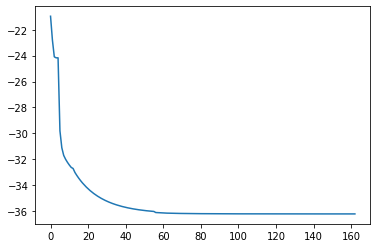

In [ ]:
plt.plot(function_values)

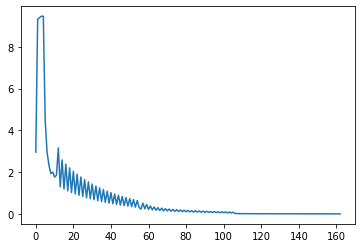

In [ ]:
plt.plot(derivative_values)

Text(0, 0.5, 'No of Iterations')

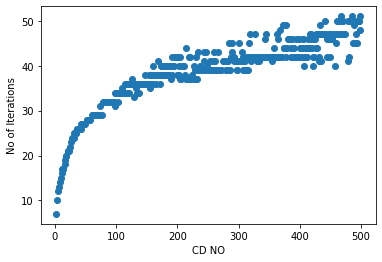

In [ ]:
plt.scatter(CD_matrix,iterations)
plt.xlabel("CD NO")
plt.ylabel("No of Iterations")

In [ ]:
import numpy as npo
def drawPlots(function,x_values,xmin=-3,xmax=3,ymin=-3,ymax=3):
  xmesh, ymesh = npo.mgrid[xmin:xmax:50j,ymin:ymax:50j]
  fmesh=np.zeros((50,50))
  for i in range(50):
    for j in range(50):
      fmesh[i][j]=function(torch.tensor(np.array([xmesh[i][j],ymesh[i][j]])).reshape(-1,1)).detach().numpy()
  fig = plt.figure()
  ax = fig.gca(projection="3d")
  ax.plot_surface(xmesh, ymesh, fmesh)

  print("")
  fig = plt.figure()
  plt.axis("equal")
  plt.contour(xmesh, ymesh, fmesh)

  print("")
  fig = plt.figure()
  plt.axis("equal")
  plt.contour(xmesh, ymesh, fmesh, 50)
  it_array = np.array(x_values).reshape(len(x_values),2)
  plt.plot(it_array.T[0], it_array.T[1], "x-")

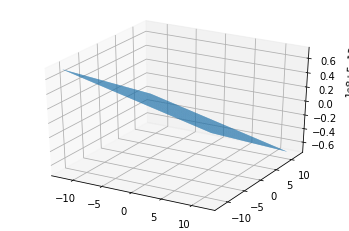

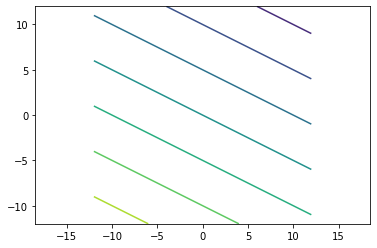

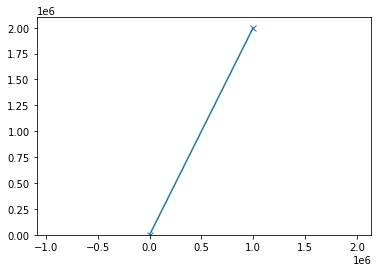

In [ ]:
drawPlots(function_,x_values,xmin=-12,xmax=12,ymin=-12,ymax=12)

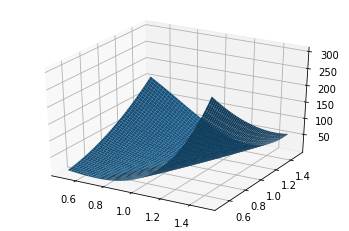

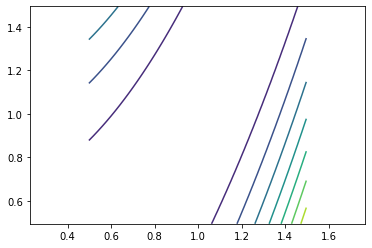

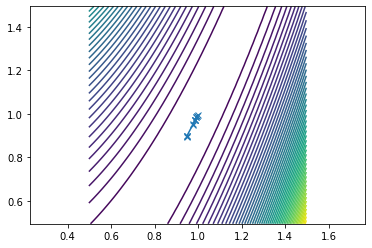

In [ ]:
k=0.5
drawPlots(function_,x_values[-15:], x_gc[0]-k,x_gc[0]+k,x_gc[1]-k, x_gc[1]+k)

In [ ]:
def drawPlots2D(function,x_values,xmin=-1,xmax=1):
  xmesh = np.linspace(xmin,xmax,50)
  fmesh=np.zeros(50)
  for i in range(50):
      fmesh[i]=function(torch.tensor(np.array([xmesh[i]]))).detach().numpy()
  fig = plt.figure()
  plt.plot(xmesh, fmesh)

  print("")
  fig = plt.figure()

  it_array = np.array(x_values).reshape(len(x_values),1)
  plt.plot(xmesh, fmesh)

  plt.plot(it_array.T[0],np.zeros(len(x_values)), "x-")

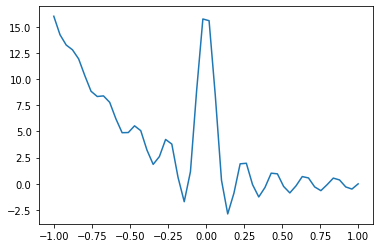

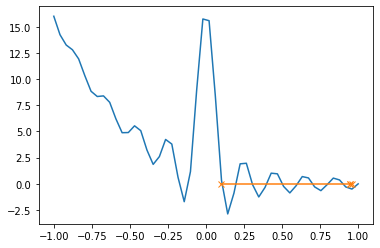

In [ ]:
drawPlots2D(GRAMACY_LEE_FUNCTION,x_values)

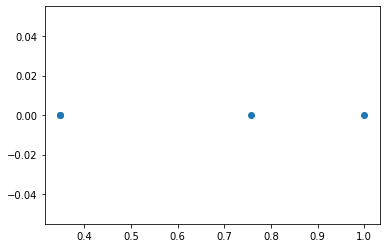

In [ ]:
plt.scatter(np.array(x_values).T[0], np.zeros(4))

In [ ]:
np.array(x_values).T[0]

array([0.01      , 1.78614179, 0.14383846, 0.14380654])